In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
# PyMC3 for Bayesian Inference
import pymc3 as pm

This code run in my Colab for checking the Bayesian linear regression, which is based on CARLOS SOUZA. It explored the Bayesian Linear Regression in 3 steps:

1:use simple features: Patients,Weeks, FVC

2.My motivation and innovation to use log value of FVC and add different features one by one in the regression formula, result improved

3.In the last step, I try to merge the categorical feature: SmokingStatus:NonSmoking and Smoking prior to one and check the results.

In [2]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df_train = pd.read_csv("/content/drive/MyDrive/Kaggle_ML/OSIC/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Kaggle_ML/OSIC/test.csv")

In [4]:
#df_train = df_train[~df_train['Patient'].isin(df_test['Patient'].unique())]
df_train = pd.concat([df_train, df_test], axis=0, ignore_index=True).drop_duplicates()

In [5]:
#label encoder for patientid
le_id = LabelEncoder()
df_train['PatientID'] = le_id.fit_transform(df_train['Patient'])

# the log value of FVC is more approporiate in this case
df_train['FVC_base'] = df_train['FVC']
df_train['FVC'] = np.log(df_train['FVC'])

df_train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,PatientID,FVC_base
0,ID00007637202177411956430,-4,7.747165,58.253649,79,Male,Ex-smoker,0,2315
1,ID00007637202177411956430,5,7.702556,55.712129,79,Male,Ex-smoker,0,2214
2,ID00007637202177411956430,7,7.630947,51.862104,79,Male,Ex-smoker,0,2061
3,ID00007637202177411956430,9,7.670429,53.950679,79,Male,Ex-smoker,0,2144
4,ID00007637202177411956430,11,7.634821,52.063412,79,Male,Ex-smoker,0,2069


In [6]:
#One-Hot encode for category features:sex and smokingstatus
COLS = ['Sex','SmokingStatus']
for col in COLS:
    for mod in df_train[col].unique():
        df_train[mod] = (df_train[col] == mod).astype(int)

In [7]:
df_train

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,PatientID,FVC_base,Male,Female,Ex-smoker,Never smoked,Currently smokes
0,ID00007637202177411956430,-4,7.747165,58.253649,79,Male,Ex-smoker,0,2315,1,0,1,0,0
1,ID00007637202177411956430,5,7.702556,55.712129,79,Male,Ex-smoker,0,2214,1,0,1,0,0
2,ID00007637202177411956430,7,7.630947,51.862104,79,Male,Ex-smoker,0,2061,1,0,1,0,0
3,ID00007637202177411956430,9,7.670429,53.950679,79,Male,Ex-smoker,0,2144,1,0,1,0,0
4,ID00007637202177411956430,11,7.634821,52.063412,79,Male,Ex-smoker,0,2069,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1544,ID00426637202313170790466,13,7.905442,66.594637,73,Male,Never smoked,175,2712,1,0,0,1,0
1545,ID00426637202313170790466,19,7.999007,73.126412,73,Male,Never smoked,175,2978,1,0,0,1,0
1546,ID00426637202313170790466,31,7.975221,71.407524,73,Male,Never smoked,175,2908,1,0,0,1,0
1547,ID00426637202313170790466,43,7.997999,73.052745,73,Male,Never smoked,175,2975,1,0,0,1,0


In [8]:
df1 = df_train[['Patient', 'Weeks', 'Percent']].sort_values(by=['Patient', 'Weeks'])
df1 = df_train.groupby('Patient').head(1)
df1 = df1.rename(columns={'Percent': 'Percent_base'})
df_train = pd.merge(df_train, df1[['Patient', 'Percent_base']], how='left',on='Patient')
df_train

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,PatientID,FVC_base,Male,Female,Ex-smoker,Never smoked,Currently smokes,Percent_base
0,ID00007637202177411956430,-4,7.747165,58.253649,79,Male,Ex-smoker,0,2315,1,0,1,0,0,58.253649
1,ID00007637202177411956430,5,7.702556,55.712129,79,Male,Ex-smoker,0,2214,1,0,1,0,0,58.253649
2,ID00007637202177411956430,7,7.630947,51.862104,79,Male,Ex-smoker,0,2061,1,0,1,0,0,58.253649
3,ID00007637202177411956430,9,7.670429,53.950679,79,Male,Ex-smoker,0,2144,1,0,1,0,0,58.253649
4,ID00007637202177411956430,11,7.634821,52.063412,79,Male,Ex-smoker,0,2069,1,0,1,0,0,58.253649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1544,ID00426637202313170790466,13,7.905442,66.594637,73,Male,Never smoked,175,2712,1,0,0,1,0,71.824968
1545,ID00426637202313170790466,19,7.999007,73.126412,73,Male,Never smoked,175,2978,1,0,0,1,0,71.824968
1546,ID00426637202313170790466,31,7.975221,71.407524,73,Male,Never smoked,175,2908,1,0,0,1,0,71.824968
1547,ID00426637202313170790466,43,7.997999,73.052745,73,Male,Never smoked,175,2975,1,0,0,1,0,71.824968


Our model can be describes as:
$$
FVC_{ij} \sim \mathcal{N}(\alpha_i + X_{ij} \beta_i, \sigma)
$$

Reference: Carlos Souza's Bayesian notebook

​
$X_{ij}$ is a vector of the patient *i* at timestep *j* :Male ;Ex-smoker;Currently-smokes;Percent from patient *i* at baseline moment;The week 


prior distributions for the parameters

# Step 1:Firstly, I try simple model, then extend to more different features

In [9]:
num_patients =df_train['Patient'].nunique()
FVC_obs = df_train['FVC'].values
Weeks = df_train['Weeks'].values
PatientID = df_train['PatientID'].values

In [10]:
with pm.Model() as model_base:
    # create shared variables 
    FVC_obs_shared = pm.Data("FVC_obs_shared", FVC_obs)
    Weeks_shared = pm.Data('Weeks_shared', Weeks)
    PatientID_shared = pm.Data('PatientID_shared', PatientID)
    
    mu_a = pm.Normal('mu_a', mu=1700., sigma=400)
    sigma_a = pm.HalfNormal('sigma_a', 1000.)
    mu_b = pm.Normal('mu_b', mu=-4., sigma=1)
    sigma_b = pm.HalfNormal('sigma_b', 5.)

    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=num_patients)
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=num_patients)

    # Model error
    sigma = pm.HalfNormal('sigma', 150.)

    FVC_est = a[PatientID_shared] + b[PatientID_shared] * Weeks_shared

    # Data likelihood
    FVC_like = pm.Normal('FVC_like', mu=FVC_est,
                         sigma=sigma, observed=FVC_obs_shared)
    
    # Fitting the model
    trace_base = pm.sample(1500, tune=2000, target_accept=.9, init="adapt_diag",return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 2_000 tune and 1_500 draw iterations (4_000 + 3_000 draws total) took 400 seconds.


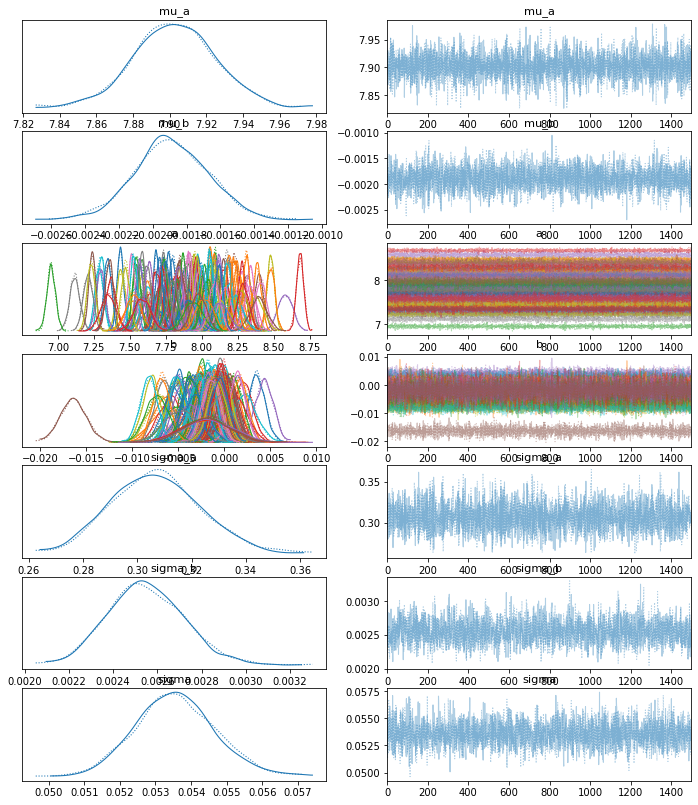

In [11]:
with model_base:
    pm.plot_trace(trace_base);

In [12]:
pred_df = []
for i in range(df_train['Patient'].nunique()):
    df = pd.DataFrame(columns=['PatientID', 'Weeks'])
    df['Weeks'] = np.arange(-12, 134)
    df['PatientID'] = i
    pred_df.append(df)
pred_df = pd.concat(pred_df, ignore_index=True)
pred_df

,PatientID,Weeks
0,0,-12
1,0,-11
2,0,-10
3,0,-9
4,0,-8
...,...,...
25691,175,129
25692,175,130
25693,175,131
25694,175,132


In [13]:
with model_base:
    pm.set_data({
        "PatientID_shared": pred_df['PatientID'].values.astype(int),
        "Weeks_shared": pred_df['Weeks'].values.astype(int),
        "FVC_obs_shared": np.zeros(len(pred_df)).astype(int),
    })
    posterior_pred = pm.sample_posterior_predictive(trace_base)

In [14]:
df = pd.DataFrame(columns=['Patient', 'Weeks', 'FVC_pred', 'sigma'])
df['Patient'] = le_id.inverse_transform(pred_df['PatientID'])
df['Weeks'] = pred_df['Weeks']
df['FVC_pred'] = posterior_pred['FVC_like'].T.mean(axis=1)
df['sigma'] = posterior_pred['FVC_like'].T.std(axis=1)
df

,Patient,Weeks,FVC_pred,sigma
0,ID00007637202177411956430,-12,7.705781,0.062657
1,ID00007637202177411956430,-11,7.702794,0.062704
2,ID00007637202177411956430,-10,7.701305,0.060855
3,ID00007637202177411956430,-9,7.701424,0.061736
4,ID00007637202177411956430,-8,7.699304,0.061435
...,...,...,...,...
25691,ID00426637202313170790466,129,7.738781,0.332205
25692,ID00426637202313170790466,130,7.736020,0.334635
25693,ID00426637202313170790466,131,7.732396,0.339163
25694,ID00426637202313170790466,132,7.729014,0.342324


In [15]:
original_train = pd.read_csv("/content/drive/MyDrive/Kaggle_ML/OSIC/train.csv")
df = pd.merge(df, original_train[['Patient', 'Weeks', 'FVC']], how='left', on=['Patient', 'Weeks'])
df= df.dropna()

In [16]:
df

,Patient,Weeks,FVC_pred,sigma,FVC
8,ID00007637202177411956430,-4,7.692754,0.060224,2315.0
17,ID00007637202177411956430,5,7.678876,0.058483,2214.0
19,ID00007637202177411956430,7,7.676537,0.057322,2061.0
21,ID00007637202177411956430,9,7.672336,0.056564,2144.0
23,ID00007637202177411956430,11,7.669960,0.056374,2069.0
...,...,...,...,...,...
25582,ID00426637202313170790466,13,7.954491,0.080616,2712.0
25588,ID00426637202313170790466,19,7.940323,0.085980,2978.0
25600,ID00426637202313170790466,31,7.921624,0.106990,2908.0
25612,ID00426637202313170790466,43,7.897766,0.131220,2975.0


In [17]:
#Calculate Laplace Log Likelihood
sigma_c = df['sigma'].values
sigma_c[sigma_c < 70] = 70
delta = (df['FVC_pred'] - df['FVC']).abs()
delta[delta > 1000] = 1000
Metrics = - np.sqrt(2) * delta / sigma_c - np.log(np.sqrt(2) * sigma_c)
print(f'Laplace Log Likelihood: {Metrics.mean():.4f}')

Laplace Log Likelihood: -24.7853


# Step 2:Now take more variales into consideration and repeat the same process since previous Laplace Log Likelihood is not good

In [9]:
#For example: take smoking into consideration
mu_FVC_smokers = df_train.loc[df_train['SmokingStatus'] == 'Currently smokes', 'FVC'].mean()
std_FVC_smokers = df_train.loc[df_train['SmokingStatus'] == 'Currently smokes', 'FVC'].std() / 2

In [10]:
First_week_fvc = df_train.loc[df_train['SmokingStatus'] == 'Currently smokes', ['Patient', 'Weeks']].sort_values(by = ['Patient', 'Weeks']).groupby('Patient')

In [11]:
Last_week_fvc = df_train.loc[df_train['SmokingStatus'] == 'Currently smokes', ['Patient', 'Weeks']].sort_values(by = ['Patient', 'Weeks']).groupby('Patient') 

In [12]:
First_smo=First_week_fvc["Weeks"].head(1).values
Last_smo=Last_week_fvc["Weeks"].tail(1).values

In [13]:
weeks_len_smo = (Last_smo-First_smo)
print(weeks_len_smo)

[60 56 58 57 56 55 54 56 58]


In [14]:
df_train

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,PatientID,FVC_base,Male,Female,Ex-smoker,Never smoked,Currently smokes,Percent_base
0,ID00007637202177411956430,-4,7.747165,58.253649,79,Male,Ex-smoker,0,2315,1,0,1,0,0,58.253649
1,ID00007637202177411956430,5,7.702556,55.712129,79,Male,Ex-smoker,0,2214,1,0,1,0,0,58.253649
2,ID00007637202177411956430,7,7.630947,51.862104,79,Male,Ex-smoker,0,2061,1,0,1,0,0,58.253649
3,ID00007637202177411956430,9,7.670429,53.950679,79,Male,Ex-smoker,0,2144,1,0,1,0,0,58.253649
4,ID00007637202177411956430,11,7.634821,52.063412,79,Male,Ex-smoker,0,2069,1,0,1,0,0,58.253649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1544,ID00426637202313170790466,13,7.905442,66.594637,73,Male,Never smoked,175,2712,1,0,0,1,0,71.824968
1545,ID00426637202313170790466,19,7.999007,73.126412,73,Male,Never smoked,175,2978,1,0,0,1,0,71.824968
1546,ID00426637202313170790466,31,7.975221,71.407524,73,Male,Never smoked,175,2908,1,0,0,1,0,71.824968
1547,ID00426637202313170790466,43,7.997999,73.052745,73,Male,Never smoked,175,2975,1,0,0,1,0,71.824968


In [15]:
FVC_beta_mean_smo = df_train.loc[(df_train['SmokingStatus'] == 'Currently smokes') & (df_train['Weeks'] > Last_smo.mean()), 'FVC'].mean() - df_train.loc[(df_train['SmokingStatus'] == 'Currently smokes') & (df_train['Weeks'] < First_smo.mean()), 'FVC'].mean()
FVC_beta_weeks_mean_smo = FVC_beta_mean_smo / weeks_len_smo.mean()
FVC_beta_others = 1
FVC_beta_weeks_mean_smo 

0.0037115323208783044

In [16]:
# Data used to update priors, repeat the same process
n_patients_smo = df_train.loc[df_train['Currently smokes'] == 1, 'Patient'].nunique()
FVC_obs_smo = df_train.loc[df_train['Currently smokes'] == 1, 'FVC'].values
PatientID_smo = df_train.loc[df_train['Currently smokes'] == 1, 'PatientID'].values
Weeks_smo = df_train.loc[df_train['Currently smokes'] == 1, 'Weeks'].values
Male_smo = df_train.loc[df_train['Currently smokes'] == 1, 'Male'].values
Percent_smo = df_train.loc[df_train['Currently smokes'] == 1, 'Percent_base'].values

In [17]:
print(n_patients_smo)

9


In [18]:
Percent_smo 

array([ 99.79480164,  99.79480164,  99.79480164,  99.79480164,
        99.79480164,  99.79480164,  99.79480164,  99.79480164,
        99.79480164,  79.6145494 ,  79.6145494 ,  79.6145494 ,
        79.6145494 ,  79.6145494 ,  79.6145494 ,  79.6145494 ,
        79.6145494 ,  79.6145494 ,  90.09087732,  90.09087732,
        90.09087732,  90.09087732,  90.09087732,  90.09087732,
        90.09087732,  90.09087732,  90.09087732,  90.09087732,
        73.79053695,  73.79053695,  73.79053695,  73.79053695,
        73.79053695,  73.79053695,  73.79053695,  73.79053695,
        73.79053695,  80.54109124,  80.54109124,  80.54109124,
        80.54109124,  80.54109124,  80.54109124,  80.54109124,
        80.54109124,  80.54109124,  83.56277533,  83.56277533,
        83.56277533,  83.56277533,  83.56277533,  83.56277533,
        83.56277533,  83.56277533,  83.56277533,  94.64436662,
        94.64436662,  94.64436662,  94.64436662,  94.64436662,
        94.64436662,  94.64436662,  94.64436662,  94.64

In [19]:
with pm.Model() as model_smo:
    # create shared variables 
    FVC_obs_shared = pm.Data("FVC_obs_shared", FVC_obs_smo)
    PatientID_shared = pm.Data('PatientID_shared', PatientID_smo)
    Weeks_shared = pm.Data('Weeks_shared', Weeks_smo)
    Male_shared = pm.Data('Male_shared', Male_smo)
    Percent_shared = pm.Data('Percent_shared', Percent_smo)
    # Model parameter priors
    a = pm.Normal('a', mu = mu_FVC_smokers, sigma = std_FVC_smokers)
    b_week = pm.Normal('b_week', mu = FVC_beta_weeks_mean_smo, sigma = 1.)
    b_gender = pm.Normal('b_gender', mu = 0, sigma = FVC_beta_others)
    b_weeks_gender = pm.Normal('b_weeks_gender', mu = 0, sigma = FVC_beta_others)
    b_percent = pm.Normal('b_percent', mu = 0, sigma = FVC_beta_others)
    # Model error
    sigma = pm.HalfNormal('sigma', np.log(70.))
    # Model formula
    FVC_est = a + b_week * Weeks_shared + b_gender * Male_shared + b_weeks_gender * Weeks_shared * Male_shared + b_percent * Percent_shared
    # Data likelihood
    FVC_like = pm.Normal('FVC_like', mu = FVC_est, sigma = sigma, observed = FVC_obs_shared)

    # Fitting the model
    trace_smo = pm.sample(1500, tune=15000, target_accept=.9, init="adapt_diag",return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, b_percent, b_weeks_gender, b_gender, b_week, a]


Sampling 2 chains for 15_000 tune and 1_500 draw iterations (30_000 + 3_000 draws total) took 167 seconds.


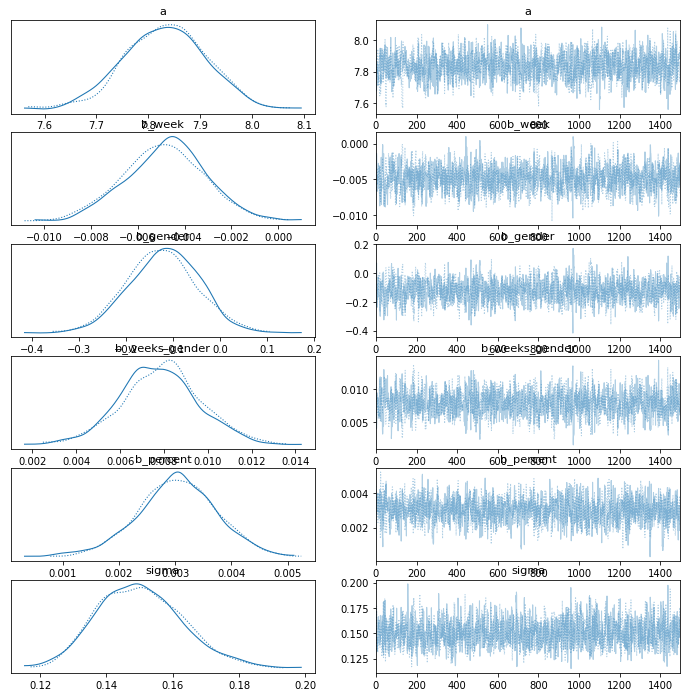

In [20]:
with model_smo:
    pm.plot_trace(trace_smo);

In [21]:
df_new = df_train.groupby('Patient').first().reset_index()
pred_df = []
for i in range(df_train['Patient'].nunique()):
    df = pd.DataFrame(columns=['PatientID', 'Weeks'])
    df['Weeks'] = np.arange(-12, 134)
    df['PatientID'] = i
    df['Male'] = df_new[df_new['PatientID'] == i]['Male'].values[0]
    df['Currently smokes'] =df_new[df_new['PatientID'] == i]['Currently smokes'].values[0]
    df['Percent_base'] = df_new[df_new['PatientID'] == i]['Percent_base'].values[0]
    pred_df.append(df)
pred_df = pd.concat(pred_df, ignore_index=True)
pred_df

,PatientID,Weeks,Male,Currently smokes,Percent_base
0,0,-12,1,0,58.253649
1,0,-11,1,0,58.253649
2,0,-10,1,0,58.253649
3,0,-9,1,0,58.253649
4,0,-8,1,0,58.253649
...,...,...,...,...,...
25691,175,129,1,0,71.824968
25692,175,130,1,0,71.824968
25693,175,131,1,0,71.824968
25694,175,132,1,0,71.824968


In [22]:
df_new

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,PatientID,FVC_base,Male,Female,Ex-smoker,Never smoked,Currently smokes,Percent_base
0,ID00007637202177411956430,-4,7.747165,58.253649,79,Male,Ex-smoker,0,2315,1,0,1,0,0,58.253649
1,ID00009637202177434476278,8,8.205218,85.282878,69,Male,Ex-smoker,1,3660,1,0,1,0,0,85.282878
2,ID00010637202177584971671,0,8.167068,94.724672,60,Male,Ex-smoker,2,3523,1,0,1,0,0,94.724672
3,ID00011637202177653955184,6,8.109526,85.987590,72,Male,Ex-smoker,3,3326,1,0,1,0,0,85.987590
4,ID00012637202177665765362,33,8.136811,93.726006,65,Male,Never smoked,4,3418,1,0,0,1,0,93.726006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,ID00419637202311204720264,6,8.013012,70.186855,73,Male,Ex-smoker,171,3020,1,0,1,0,0,70.186855
172,ID00421637202311550012437,15,7.915348,82.045291,68,Male,Ex-smoker,172,2739,1,0,1,0,0,82.045291
173,ID00422637202311677017371,6,7.565275,76.672493,73,Male,Ex-smoker,173,1930,1,0,1,0,0,76.672493
174,ID00423637202312137826377,17,8.099858,79.258903,72,Male,Ex-smoker,174,3294,1,0,1,0,0,79.258903


In [23]:
df_train.shape

(1549, 15)

In [24]:
with model_smo:
    pm.set_data({
        "PatientID_shared": pred_df.loc[pred_df['Currently smokes'] == 1, 'PatientID'].values.astype(int),
        "Weeks_shared": pred_df.loc[pred_df['Currently smokes'] == 1, 'Weeks'].values.astype(int),
        "Male_shared": pred_df.loc[pred_df['Currently smokes'] == 1, 'Male'].values.astype(int),
        "Percent_shared": pred_df.loc[pred_df['Currently smokes'] == 1, 'Percent_base'].values,
        "FVC_obs_shared": np.zeros(len(pred_df.loc[pred_df['Currently smokes'] == 1, :])).astype(int),
    })
    posterior_pred = pm.sample_posterior_predictive(trace_smo)

In [25]:
patients_train_smo = df_train.loc[df_train['SmokingStatus'] == 'Currently smokes', 'Patient'].unique().tolist()

In [26]:
df_train['Patient'].isin(patients_train_smo )

0       False
1       False
2       False
3       False
4       False
        ...  
1544    False
1545    False
1546    False
1547    False
1548    False
Name: Patient, Length: 1549, dtype: bool

In [27]:
df = pd.DataFrame(columns=['Patient', 'Weeks', 'FVC_pred', 'sigma'])
df['Patient'] = le_id.inverse_transform(pred_df['PatientID'])
df['Weeks'] = pred_df['Weeks']
df.loc[df['Patient'].isin(patients_train_smo), 'FVC_pred'] = np.exp(posterior_pred['FVC_like'].T.mean(axis=1))
df.loc[df['Patient'].isin(patients_train_smo), 'sigma'] = np.exp(posterior_pred['FVC_like'].T.std(axis=1))
df

,Patient,Weeks,FVC_pred,sigma
0,ID00007637202177411956430,-12,NaN,NaN
1,ID00007637202177411956430,-11,NaN,NaN
2,ID00007637202177411956430,-10,NaN,NaN
3,ID00007637202177411956430,-9,NaN,NaN
4,ID00007637202177411956430,-8,NaN,NaN
...,...,...,...,...
25691,ID00426637202313170790466,129,NaN,NaN
25692,ID00426637202313170790466,130,NaN,NaN
25693,ID00426637202313170790466,131,NaN,NaN
25694,ID00426637202313170790466,132,NaN,NaN


In [28]:
original_train = pd.read_csv("/content/drive/MyDrive/Kaggle_ML/OSIC/train.csv")
df = pd.merge(df, original_train[['Patient', 'Weeks', 'FVC']], how='left', on=['Patient', 'Weeks'])
df= df.dropna()

In [29]:
df

,Patient,Weeks,FVC_pred,sigma,FVC
4851,ID00082637202201836229724,19,3125.90935,1.171242,2918.0
4859,ID00082637202201836229724,27,2985.505079,1.167795,2955.0
4861,ID00082637202201836229724,29,2978.719424,1.171858,2873.0
4863,ID00082637202201836229724,31,2949.162696,1.167992,2963.0
4865,ID00082637202201836229724,33,2930.321344,1.170099,2885.0
...,...,...,...,...,...
21368,ID00355637202295106567614,34,3790.317227,1.168535,4514.0
21374,ID00355637202295106567614,40,3861.171404,1.171403,4762.0
21386,ID00355637202295106567614,52,4006.318488,1.170419,4730.0
21399,ID00355637202295106567614,65,4169.3496,1.164933,4791.0


In [30]:
#Calculate Laplace Log Likelihood
sigma_c = df['sigma'].values.astype('float64')
sigma_c[sigma_c < 70] = 70
delta = (df['FVC_pred'] - df['FVC']).abs()
delta[delta > 1000] = 1000
Metrics = - np.sqrt(2) * delta / sigma_c - np.log(np.sqrt(2) * sigma_c)
print(f'Laplace Log Likelihood: {Metrics.mean():.4f}')

Laplace Log Likelihood: -11.7629


# Step 3:Finally, we add NonSmoker into regression model to check the Laplace Log likelihood

In [31]:
#For example: take smoking into consideration
mu_FVC_nosmokers = df_train.loc[df_train['SmokingStatus'] != 'Currently smokes', 'FVC'].mean()
std_FVC_nosmokers = df_train.loc[df_train['SmokingStatus'] != 'Currently smokes', 'FVC'].std() / 2

In [32]:
First_week_fvc_no = df_train.loc[df_train['SmokingStatus'] != 'Currently smokes', ['Patient', 'Weeks']].sort_values(by = ['Patient', 'Weeks']).groupby('Patient')

In [33]:
Last_week_fvc_no = df_train.loc[df_train['SmokingStatus'] != 'Currently smokes', ['Patient', 'Weeks']].sort_values(by = ['Patient', 'Weeks']).groupby('Patient') 

In [34]:
First_nosmo=First_week_fvc_no["Weeks"].head(1).values
Last_nosmo=Last_week_fvc_no["Weeks"].tail(1).values

In [35]:
weeks_len_nosmo = (Last_nosmo-First_nosmo)

In [36]:
FVC_beta_mean_nosmo = df_train.loc[(df_train['SmokingStatus'] != 'Currently smokes') & (df_train['Weeks'] > Last_smo.mean()), 'FVC'].mean() - df_train.loc[(df_train['SmokingStatus'] != 'Currently smokes') & (df_train['Weeks'] < First_smo.mean()), 'FVC'].mean()
FVC_beta_weeks_mean_nosmo = FVC_beta_mean_smo / weeks_len_smo.mean()
FVC_beta_others_no = 1


In [37]:
# Data used to update priors, repeat the same process
n_patients_nosmo = df_train.loc[df_train['Currently smokes'] == 0, 'Patient'].nunique()
FVC_obs_nosmo = df_train.loc[df_train['Currently smokes'] == 0, 'FVC'].values
PatientID_nosmo = df_train.loc[df_train['Currently smokes'] == 0, 'PatientID'].values
Weeks_nosmo = df_train.loc[df_train['Currently smokes'] == 0, 'Weeks'].values
Male_nosmo = df_train.loc[df_train['Currently smokes'] == 0, 'Male'].values
Percent_nosmo = df_train.loc[df_train['Currently smokes'] == 0, 'Percent_base'].values

In [38]:
with pm.Model() as model_nosmo:
    # create shared variables 
    FVC_obs_shared = pm.Data("FVC_obs_shared", FVC_obs_nosmo)
    PatientID_shared = pm.Data('PatientID_shared', PatientID_nosmo)
    Weeks_shared = pm.Data('Weeks_shared', Weeks_nosmo)
    Male_shared = pm.Data('Male_shared', Male_nosmo)
    Percent_shared = pm.Data('Percent_shared', Percent_nosmo)
    # Model parameter priors
    a = pm.Normal('a', mu = mu_FVC_nosmokers, sigma = std_FVC_nosmokers)
    b_week = pm.Normal('b_week', mu = FVC_beta_weeks_mean_nosmo, sigma = 1.)
    b_gender = pm.Normal('b_gender', mu = 0, sigma = FVC_beta_others_no)
    b_weeks_gender = pm.Normal('b_weeks_gender', mu = 0, sigma = FVC_beta_others_no)
    b_percent = pm.Normal('b_percent', mu = 0, sigma = FVC_beta_others_no)
    # Model error
    sigma = pm.HalfNormal('sigma', np.log(70.))
    # Model formula
    FVC_est = a + b_week * Weeks_shared + b_gender * Male_shared + b_weeks_gender * Weeks_shared * Male_shared + b_percent * Percent_shared
    # Data likelihood
    FVC_like = pm.Normal('FVC_like', mu = FVC_est, sigma = sigma, observed = FVC_obs_shared)

    # Fitting the model
    trace_nosmo = pm.sample(1500, tune=15000, target_accept=.9, init="adapt_diag",return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, b_percent, b_weeks_gender, b_gender, b_week, a]


Sampling 2 chains for 15_000 tune and 1_500 draw iterations (30_000 + 3_000 draws total) took 224 seconds.


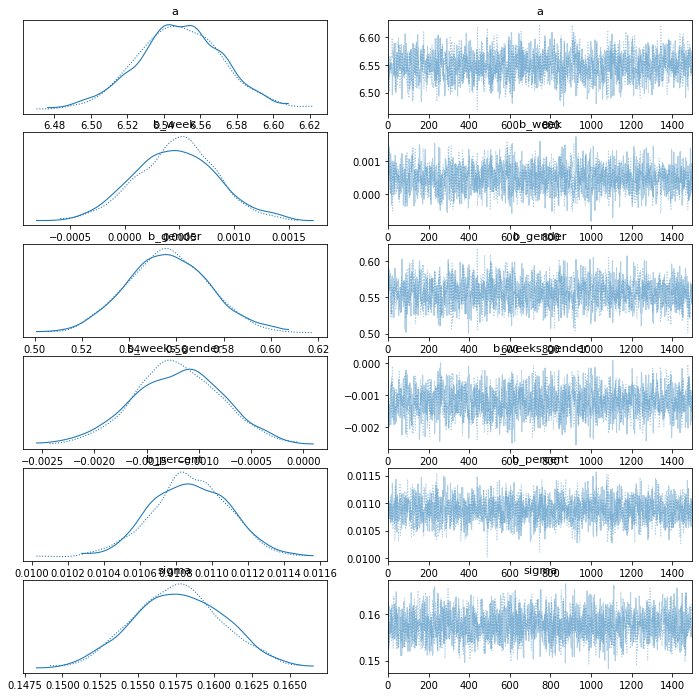

In [39]:
with model_nosmo:
    pm.plot_trace(trace_nosmo);

In [40]:
df_new = df_train.groupby('Patient').first().reset_index()
pred_df = []
for i in range(df_train['Patient'].nunique()):
    df = pd.DataFrame(columns=['PatientID', 'Weeks'])
    df['Weeks'] = np.arange(-12, 134)
    df['PatientID'] = i
    df['Male'] = df_new[df_new['PatientID'] == i]['Male'].values[0]
    df['Currently smokes'] =df_new[df_new['PatientID'] == i]['Currently smokes'].values[0]
    df['Percent_base'] = df_new[df_new['PatientID'] == i]['Percent_base'].values[0]
    pred_df.append(df)
pred_df = pd.concat(pred_df, ignore_index=True)
pred_df

,PatientID,Weeks,Male,Currently smokes,Percent_base
0,0,-12,1,0,58.253649
1,0,-11,1,0,58.253649
2,0,-10,1,0,58.253649
3,0,-9,1,0,58.253649
4,0,-8,1,0,58.253649
...,...,...,...,...,...
25691,175,129,1,0,71.824968
25692,175,130,1,0,71.824968
25693,175,131,1,0,71.824968
25694,175,132,1,0,71.824968


In [41]:
with model_nosmo:
    pm.set_data({
        "PatientID_shared": pred_df.loc[pred_df['Currently smokes'] == 0, 'PatientID'].values.astype(int),
        "Weeks_shared": pred_df.loc[pred_df['Currently smokes'] == 0, 'Weeks'].values.astype(int),
        "Male_shared": pred_df.loc[pred_df['Currently smokes'] == 0, 'Male'].values.astype(int),
        "Percent_shared": pred_df.loc[pred_df['Currently smokes'] == 0, 'Percent_base'].values,
        "FVC_obs_shared": np.zeros(len(pred_df.loc[pred_df['Currently smokes'] == 0, :])).astype(int),
    })
    posterior_pred_no = pm.sample_posterior_predictive(trace_nosmo)

In [42]:
patients_train_nosmo = df_train.loc[df_train['SmokingStatus'] != 'Currently smokes', 'Patient'].unique().tolist()

In [43]:
df = pd.DataFrame(columns=['Patient', 'Weeks', 'FVC_pred', 'sigma'])
df['Patient'] = le_id.inverse_transform(pred_df['PatientID'])
df['Weeks'] = pred_df['Weeks']
df.loc[df['Patient'].isin(patients_train_smo), 'FVC_pred'] = np.exp(posterior_pred['FVC_like'].T.mean(axis=1))
df.loc[df['Patient'].isin(patients_train_nosmo), 'FVC_pred'] = np.exp(posterior_pred_no['FVC_like'].T.mean(axis=1))
df.loc[df['Patient'].isin(patients_train_smo), 'sigma'] = np.exp(posterior_pred['FVC_like'].T.std(axis=1))
df.loc[df['Patient'].isin(patients_train_nosmo), 'sigma'] = np.exp(posterior_pred_no['FVC_like'].T.std(axis=1))
df

,Patient,Weeks,FVC_pred,sigma
0,ID00007637202177411956430,-12,2311.681606,1.173225
1,ID00007637202177411956430,-11,2311.601588,1.168003
2,ID00007637202177411956430,-10,2313.083613,1.168959
3,ID00007637202177411956430,-9,2314.401729,1.168728
4,ID00007637202177411956430,-8,2305.356438,1.173271
...,...,...,...,...
25691,ID00426637202313170790466,129,2422.903569,1.17355
25692,ID00426637202313170790466,130,2424.666988,1.177748
25693,ID00426637202313170790466,131,2404.84509,1.16968
25694,ID00426637202313170790466,132,2410.497962,1.176307


In [44]:
original_train = pd.read_csv("/content/drive/MyDrive/Kaggle_ML/OSIC/train.csv")
df = pd.merge(df, original_train[['Patient', 'Weeks', 'FVC']], how='left', on=['Patient', 'Weeks'])
df= df.dropna()

In [45]:
#Calculate Laplace Log Likelihood
sigma_c = df['sigma'].values.astype('float64')
sigma_c[sigma_c < 70] = 70
delta = (df['FVC_pred'] - df['FVC']).abs()
delta[delta > 1000] = 1000
Metrics = - np.sqrt(2) * delta / sigma_c - np.log(np.sqrt(2) * sigma_c)
print(f'Laplace Log Likelihood: {Metrics.mean():.4f}')

Laplace Log Likelihood: -10.7192
